In [6]:
#--
import sys
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace")
import map_dataset
import map_train
from models import *

sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_models
import RS_utils
#--- torch
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
#--- loss functions
from utils.losses import LabelSmoothCrossEntropy, CrossEntropyLoss
from torch.cuda.amp import GradScaler, autocast
#---
from lightning.fabric import Fabric
from lightning.fabric.loggers import CSVLogger, TensorBoardLogger
from torchmetrics.classification import Accuracy
import pandas as pd 
import os 
from sklearn.model_selection import train_test_split
import argparse
import yaml 
import timm
import numpy as np 
import time
import wandb
import random
from rich.console import Console

In [7]:
#--- argparser
parser = argparse.ArgumentParser()
parser.add_argument('--cfg', type=str, default='./configs/finetune_4.yaml')
args = parser.parse_args(args=[])
cfg = argparse.Namespace(**yaml.load(open(args.cfg), Loader=yaml.SafeLoader))
print("Model run version : ", cfg.RUN_VERSION)


Model run version :  14


In [8]:
#--- Data 
input_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Map_Your_City/building-age-dataset/"
train_path = input_path + "train/data/"
test_path = input_path + "test/data/"
train_df = pd.read_csv(input_path + "train/train-set.csv")
test_df = pd.read_csv(input_path + "test/test-set.csv") 

#--- data split 
names_data = os.listdir(train_path)
if cfg.SAMPLE:
    parse_idx = int(len(names_data) * 0.01)
    names_data = names_data[:parse_idx]
names_train, names_valid = train_test_split(names_data, test_size=0.1, random_state=1)

In [9]:
if cfg.TIMM: 
    model = timm.create_model(
    cfg.MODEL,
    pretrained=True,
    num_classes=cfg.CLASSES_NUM )
    
    #--- data config and transform
    data_config = timm.data.resolve_model_data_config(model)
    data_transform = timm.data.create_transform(**data_config, is_training=False)
    
    print("#------------------------------------")
    print(" Model Name : ",cfg.MODEL)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


In [10]:
ckpt_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/output/14_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_f1_0.64_epoch_6.pth"
model.load_state_dict(torch.load(ckpt_path))

<All keys matched successfully>

In [11]:
if cfg.TIMM:
    train_set = map_dataset.Map_Dataset_v3(names_train,train_path,max_size=data_config['input_size'][1],cfg=cfg) 
    valid_set = map_dataset.Map_Dataset_v3(names_valid,train_path,max_size=data_config['input_size'][1],cfg=cfg)  
else:
    train_set = map_dataset.Map_Dataset_v3(names_train,train_path,max_size=cfg.IMAGE_SIZE[0],cfg=cfg) 
    valid_set = map_dataset.Map_Dataset_v3(names_valid,train_path,max_size=cfg.IMAGE_SIZE[0],cfg=cfg)

In [12]:
print(train_set.__getitem__(0)[0].shape)
print(train_set.__getitem__(0)[1])

torch.Size([3, 448, 448])
0


torch.Size([1, 7])
Label :  1
Prediction :  tensor([1], device='cuda:3')


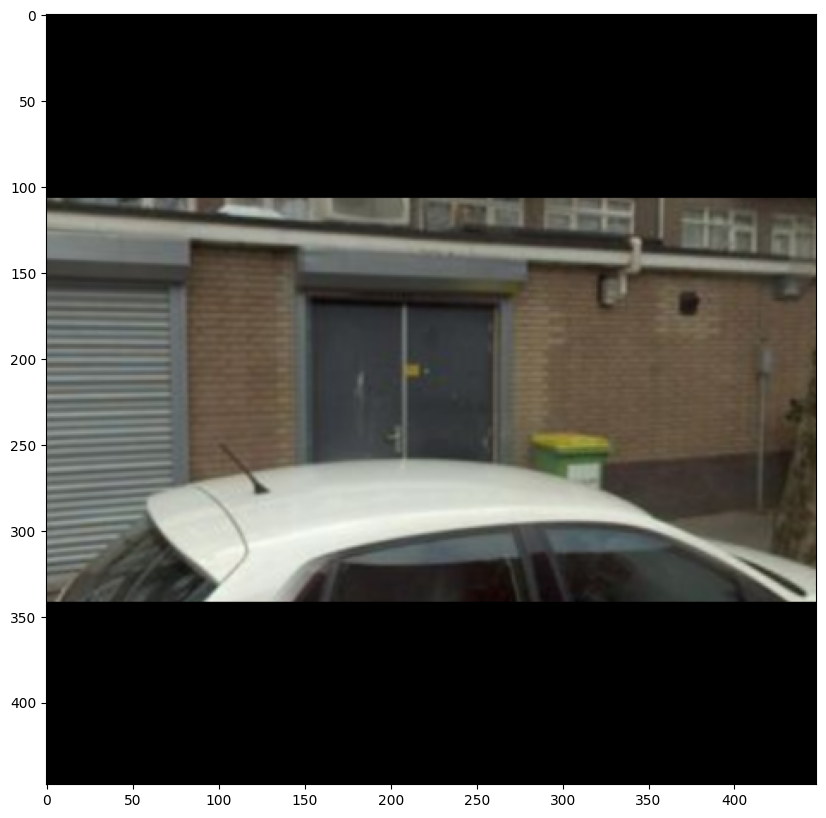

In [36]:
#--- Single image for Visualization 

#--- Test For Train Image
idx_ = random.randint(0,999)
print("idx : ", idx_)
img_torch = train_set.__getitem__(idx_)[0]
RS_utils.torch_display(img_torch, False, True)

#--- inference
device = "cuda:3"

model = model.to(device)
img_torch = img_torch.to(device)
model.eval()
img_torch = img_torch.unsqueeze(0)
preds = model(img_torch)
print(preds.shape)
preds = preds.argmax(-1)

print("Label : ",train_set.__getitem__(idx_)[1])
print("Prediction : ", preds)

In [116]:
idx_

891

idx :  371
torch.Size([1, 7])
logits :  tensor([[-2.0668, -2.7089, -1.3346, -1.6205,  3.3111,  2.9348,  1.3597]],
       device='cuda:3', grad_fn=<AddmmBackward0>)
softmax :  tensor([[0.0025, 0.0013, 0.0052, 0.0039, 0.5399, 0.3706, 0.0767]],
       device='cuda:3', grad_fn=<SoftmaxBackward0>)
Label :  5
Prediction :  tensor([4], device='cuda:3')


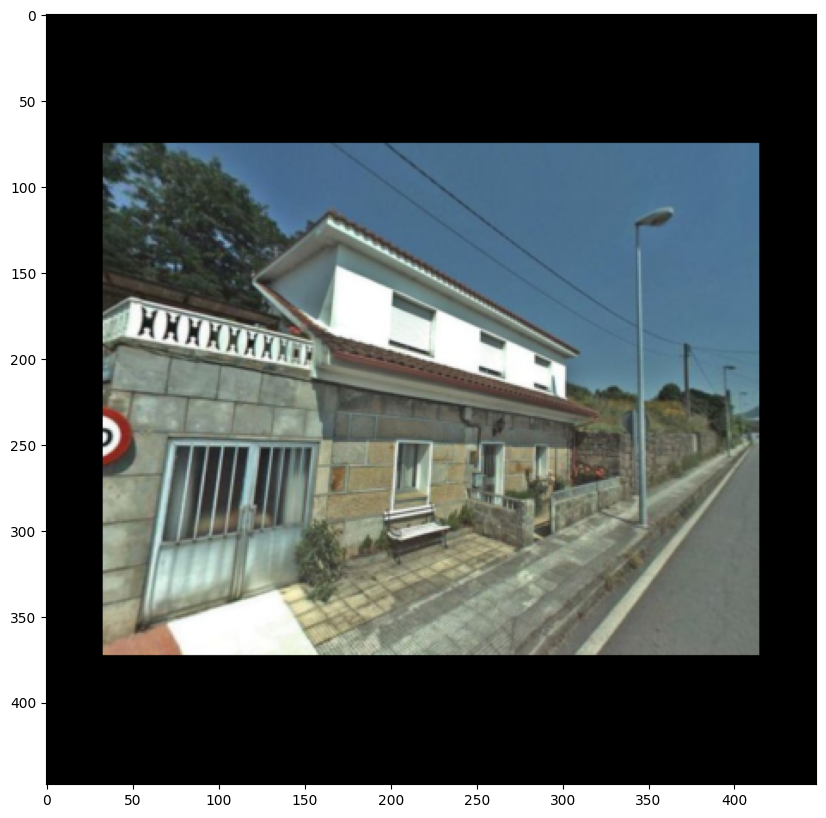

In [158]:
#--- Test For Valid Image
idx_ = random.randint(0,999)
print("idx : ", idx_)
img_torch = valid_set.__getitem__(idx_)[0]
RS_utils.torch_display(img_torch, False, True)

#--- inference
device = "cuda:3"

model = model.to(device)
img_torch = img_torch.to(device)
model.eval()
img_torch = img_torch.unsqueeze(0)
preds = model(img_torch)
print(preds.shape)
print("logits : ", preds)
print("softmax : ", preds.softmax(-1))

preds = preds.argmax(-1)

print("Label : ",valid_set.__getitem__(idx_)[1])
print("Prediction : ", preds)